XGBoost model for predicting filtered shear stress

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_squared_error
import h5py

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()}) 
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3787:136186].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

xdf = df.drop(['SS', 'Time'], axis=1)
ydf = df['SS']

print("Features:\n", xdf)
print("Shear stress:\n", ydf)


Features:
              V_filt  Vel_pc  maxFreqI_filt  freqQAmpI_filt  freqQAmpI_filt_pc
0       5489.978529     0.0  457680.400524    31438.277060                0.0
1       5489.981454     0.0  457727.638932    31421.341616                0.0
2       5489.997639     0.0  457770.778724    31409.798761                0.0
3       5490.007016     0.0  457811.889181    31398.815589                0.0
4       5490.000189     0.0  457775.514596    31395.584981                0.0
...             ...     ...            ...             ...                ...
132394  5459.380488     0.0  454414.128118    31041.955345                0.0
132395  5459.377762     0.0  454404.028108    31035.059531                0.0
132396  5459.388352     0.0  454403.709700    31020.001291                0.0
132397  5459.398820     0.0  454398.871858    31012.016780                0.0
132398  5459.399041     0.0  454410.333590    31010.874482                0.0

[132399 rows x 5 columns]
Shear stress:
 0         5

In [ ]:
# Split into train-val-test

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)   
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95327, 5)
Validation: (10592, 5)
Testing: (26480, 5)


In [ ]:
# Train the model
model = XGBRegressor(colsample_bytree=0.6, learning_rate=0.1, max_depth=4, n_estimators=1000, base_score=0.5, objective='reg:squarederror')
model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], verbose=False, early_stopping_rounds = 40)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# Evaluate the model
y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)


R^2 scores:  0.910056974636785 0.9308079478271508 0.8428495360150073
RMSE:  0.038545853294084095 0.03846213241850722 0.05741319378553523


In [ ]:
# Save the predictions

hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/xgb_ss.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()

Text(0.5, 1.0, 'Error plot for Shear Stress prediction using XGBoost model')

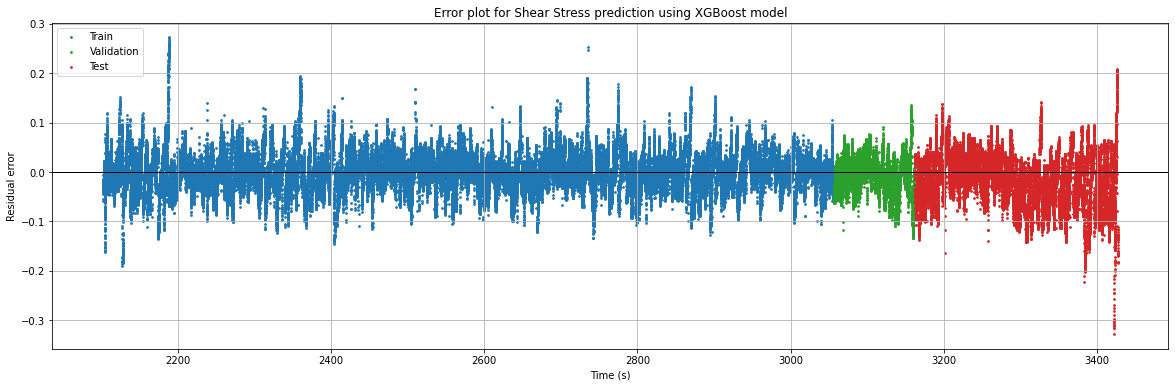

In [ ]:
# Residual plot

ttime = df1['Time']
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

Rtrain = Y_train - y_predTrain
Rval = Y_val - y_predVal
Rtest = y_test - y_predTest

fig = plt.figure(1, figsize=(20,6))
plt.scatter(traintime, Rtrain, s=3, label='Train')
plt.scatter(valtime, Rval, c='tab:green', s=3, label='Validation')
plt.scatter(testtime, Rtest, c='tab:red', s=3, label='Test')
plt.xlabel('Time (s)')
plt.ylabel('Residual error')
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.legend()
plt.title('Error plot for Shear Stress prediction using XGBoost model')


Text(0.5, 1.0, 'Shear Stress prediction using XGBoost model')

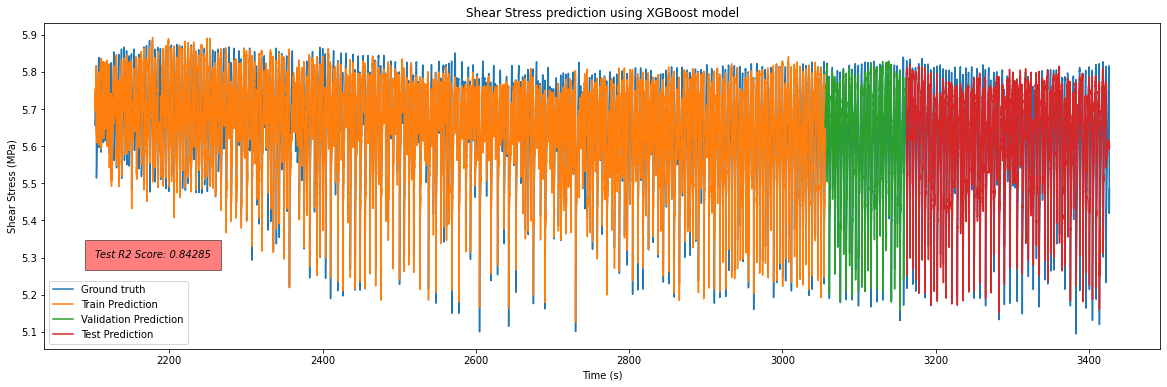

In [ ]:
# Overall plot

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using XGBoost model')


Text(0.5, 1.0, 'Detailed View, Testing Data')

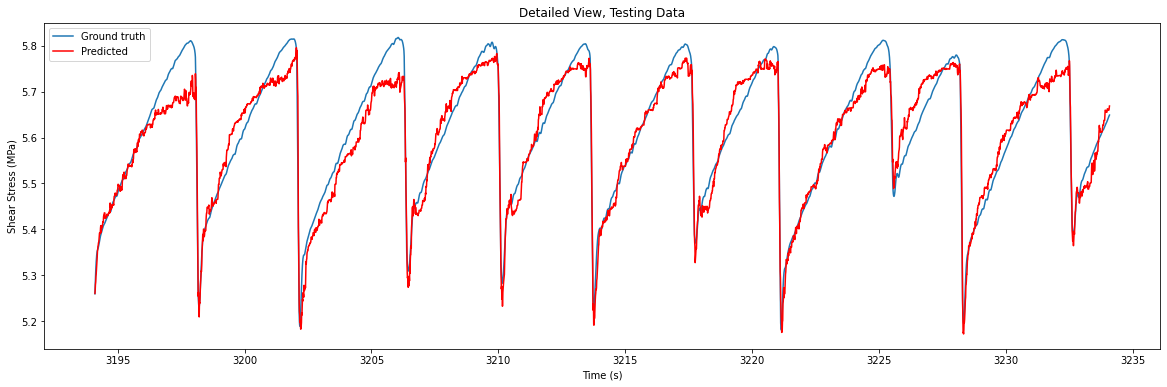

In [ ]:
# Detailed plot

n = 4000
st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


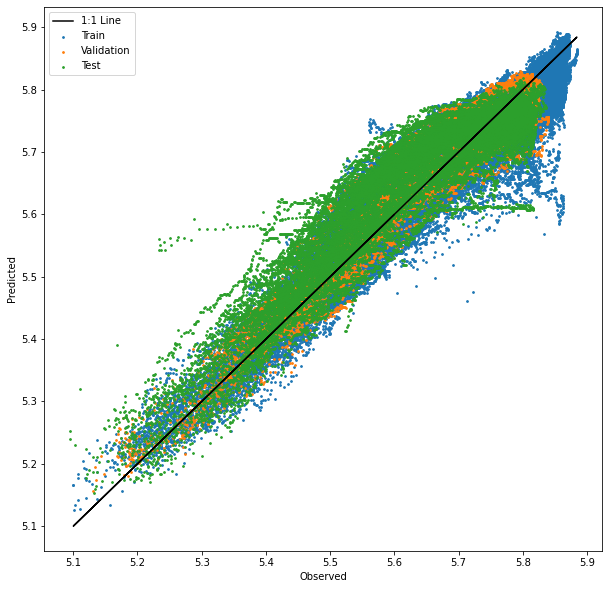

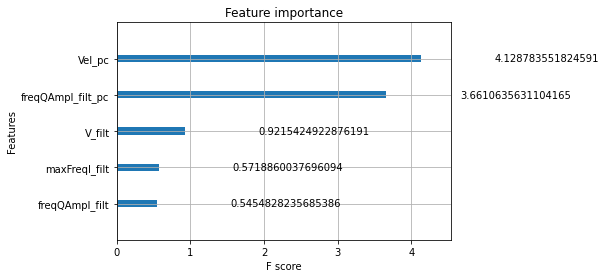

In [ ]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])

# Plot Feature importance 
plot_importance(model.get_booster().get_score(importance_type='gain'))
